In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827636 sha256=b1a105d1d1f35859360eb31c6110b70dee867b1fb4aae21661c825e546e0f9c0
  Stored in directory: /Users/anurag/Library/Caches/pip/wheels/af/2b/30/5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
  Created wheel for mdptoolbox-hiive: filename=mdptoolbox_hiive-4.0.3.1-py3-none-any.whl size=35122 sha256=6827abf29433aceeefdb86e354222ed3673a4e2127d11f364f2f35b8b3438231
  Stored in directory: /Users/anurag/Library/Caches/pip/wheels/41/46/f6/64afe48808e5822c79f31a336dd31d05ebe304d45e555fac19
Successfully built gym mdptoolbox-hiive

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import gym
from gym import wrappers
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
#from hiive.mdptoolbox.openai import OpenAI_MDPToolbox
import warnings
warnings.filterwarnings("ignore")

In [7]:
import hiive.mdptoolbox.mdp as a
dir(a)

['FiniteHorizon',
 'MDP',
 'PolicyIteration',
 'PolicyIterationModified',
 'QLearning',
 'RelativeValueIteration',
 'ValueIteration',
 'ValueIterationGS',
 '_LP',
 '_MSG_STOP_EPSILON_OPTIMAL_POLICY',
 '_MSG_STOP_EPSILON_OPTIMAL_VALUE',
 '_MSG_STOP_MAX_ITER',
 '_MSG_STOP_UNCHANGING_POLICY',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_computeDimensions',
 '_math',
 '_np',
 '_printVerbosity',
 '_sp',
 '_time',
 '_util']

In [11]:

class OpenAI_MDPToolbox:

    """Class to convert Discrete Open AI Gym environemnts to MDPToolBox environments. 
    You can find the list of available gym environments here: https://gym.openai.com/envs/#classic_control
    You'll have to look at the source code of the environments for available kwargs; as it is not well documented.  
    """
    
    def __init__(self, openAI_env_name:str, render:bool=False, **kwargs):
        """Create a new instance of the OpenAI_MDPToolbox class
        :param openAI_env_name: Valid name of an Open AI Gym env 
        :type openAI_env_name: str
        :param render: whether to render the Open AI gym env
        :type rander: boolean 
        """
        self.env_name = openAI_env_name
    
        self.env = gym.make(self.env_name, **kwargs)
        self.env.reset(seed = 5)

        if render:
            self.env.render()
        
        self.transitions = self.env.P
        self.actions = int(re.findall(r'\d+', str(self.env.action_space))[0])
        self.states = int(re.findall(r'\d+', str(self.env.observation_space))[0])
        self.P = np.zeros((self.actions, self.states, self.states))
        self.R = np.zeros((self.states, self.actions))
        self.convert_PR()
        
    def convert_PR(self):
        """Converts the transition probabilities provided by env.P to MDPToolbox-compatible P and R arrays
        """
        for state in range(self.states):
            for action in range(self.actions):
                for i in range(len(self.transitions[state][action])):
                    tran_prob = self.transitions[state][action][i][0]
                    state_ = self.transitions[state][action][i][1]
                    self.R[state][action] += tran_prob*self.transitions[state][action][i][2]
                    self.P[action, state, state_] += tran_prob

In [12]:
from gym.envs.toy_text.frozen_lake import generate_random_map

# Frozen Lake Large Grid

# Value Iteration & Policy Iteration

In [13]:
np.random.seed(23)
gen_map = generate_random_map(size=15)
mdp_prob = OpenAI_MDPToolbox('FrozenLake-v1', desc = gen_map, is_slippery=True)
mdp_p, mdp_r = mdp_prob.P, mdp_prob.R
gamma_val = [0.2,0.4,0.6,0.8, 0.9]

val_iter_df = pd.DataFrame()
pol_iter_df = pd.DataFrame()
init_time = time.time()
for i in gamma_val:
    vi = ValueIteration(mdp_p, mdp_r, gamma=i, epsilon = 0.0001)
    vi_df = pd.DataFrame(vi.run())
    vi_df['gamma'] = i
    val_iter_df = val_iter_df.append(vi_df)
    pit = PolicyIteration(mdp_p, mdp_r, gamma=i)
    pi_df = pd.DataFrame(pit.run())
    pi_df['gamma'] = i
    pol_iter_df = pol_iter_df.append(pi_df)
#     print("Value Iteration")
#     print(vi_df)
#     print("Policy Iteration")
#     print(pi_df)

print("Time taken:", time.time() - init_time)

Time taken: 6.356375217437744


In [80]:
print(pol_iter_df)
print(val_iter_df)

   State Action    Reward         Error      Time     Max V    Mean V  \
0   None   None  0.357143  2.380952e-02  0.005041  0.357143  0.011188   
1   None   None  0.358984  1.709402e-03  0.008229  0.358984  0.012084   
2   None   None  0.358984  7.660974e-06  0.009780  0.358984  0.012115   
3   None   None  0.358984  3.520623e-08  0.011428  0.358984  0.012115   
4   None   None  0.358984  3.273502e-11  0.014038  0.358984  0.012115   
5   None   None  0.358984  2.202353e-12  0.015588  0.358984  0.012115   
6   None   None  0.358984  1.591516e-13  0.016660  0.358984  0.012115   
7   None   None  0.358984  5.551115e-17  0.018539  0.358984  0.012115   
0   None   None  0.384615  5.128205e-02  0.003258  0.384615  0.012147   
1   None   None  0.394177  8.080808e-03  0.004413  0.394177  0.014591   
2   None   None  0.394177  1.482177e-04  0.006211  0.394177  0.014778   
3   None   None  0.394177  3.057677e-06  0.007790  0.394177  0.014782   
4   None   None  0.394177  2.508855e-08  0.008688  

In [21]:
print(val_iter_df)

   State Action    Reward     Error      Time     Max V    Mean V  Iteration  \
0   None   None  0.333333  0.333333  0.002437  0.333333  0.002963          1   
1   None   None  0.355556  0.044444  0.010062  0.355556  0.003556          2   
2   None   None  0.360000  0.004444  0.010652  0.360000  0.003687          3   
3   None   None  0.360494  0.000889  0.011090  0.360494  0.003716          4   
4   None   None  0.360586  0.000151  0.011686  0.360586  0.003722          5   
..   ...    ...       ...       ...       ...       ...       ...        ...   
58  None   None  0.709903  0.000017  0.007044  0.709903  0.036443         59   
59  None   None  0.709904  0.000015  0.007155  0.709904  0.036447         60   
60  None   None  0.709904  0.000013  0.007263  0.709904  0.036450         61   
61  None   None  0.709904  0.000011  0.007369  0.709904  0.036453         62   
62  None   None  0.709905  0.000010  0.007477  0.709905  0.036456         63   

    gamma  
0     0.2  
1     0.2  
2  

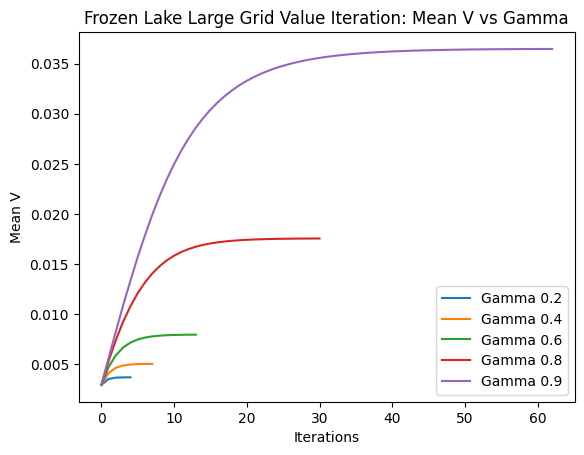

In [43]:
# Value Iteration Gamma plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Mean V'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Mean V'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Mean V'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Mean V'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Mean V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Frozen Lake Large Grid Value Iteration: Mean V vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_large_vi_meanv_gamma.png')
plt.show()

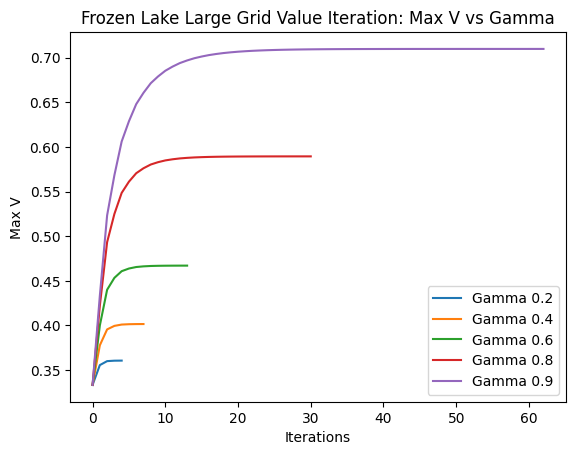

In [44]:
# Value Iteration Gamma plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Max V'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Max V'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Max V'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Max V'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Max V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Frozen Lake Large Grid Value Iteration: Max V vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_large_vi_maxv_gamma.png')
plt.show()

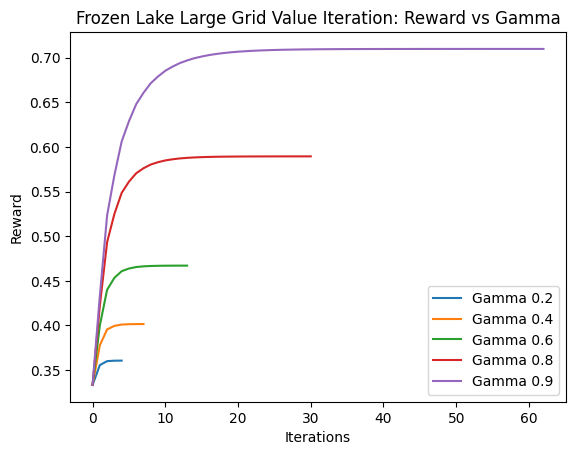

In [46]:
# Value Iteration Reward plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Reward'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Reward'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Reward'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Reward'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Reward'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Frozen Lake Large Grid Value Iteration: Reward vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_large_vi_reward_gamma.png')
plt.show()

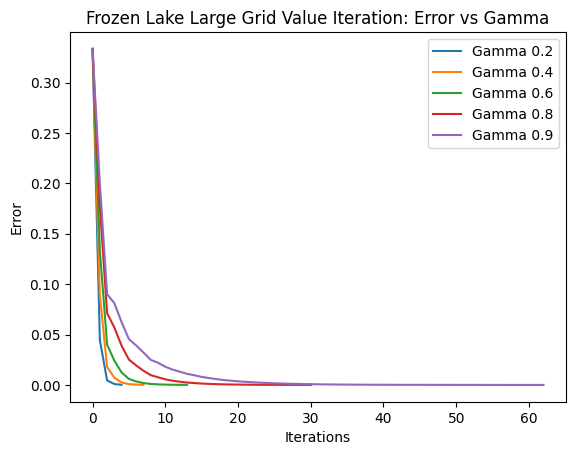

In [47]:
# Value Iteration Error plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Error'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Error'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Error'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Error'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Error'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Frozen Lake Large Grid Value Iteration: Error vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_large_vi_error_gamma.png')
plt.show()

          gamma      Time  Iteration     Max V
gamma                                         
0.2   4     0.2  0.011686          5  0.360586
0.4   7     0.4  0.000922          8  0.401566
0.6   13    0.6  0.001713         14  0.467042
0.8   30    0.8  0.003913         31  0.589476
0.9   62    0.9  0.007477         63  0.709905


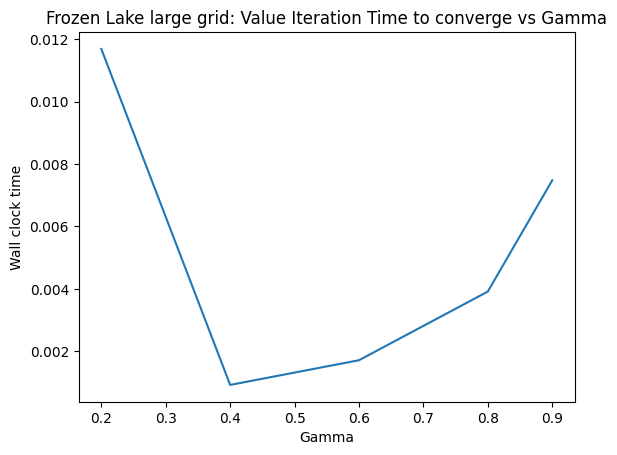

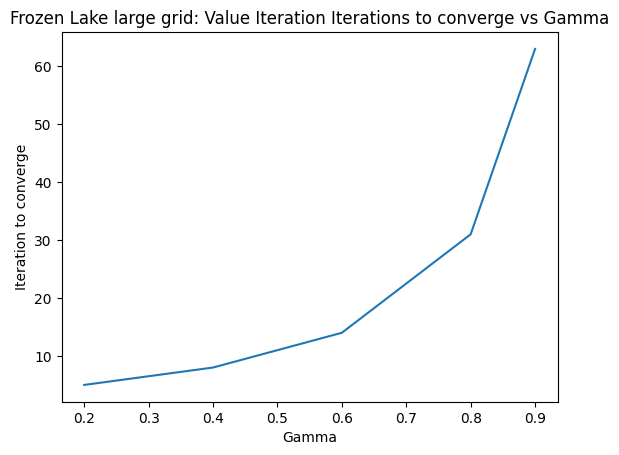

In [48]:
vlg = pd.DataFrame(val_iter_df[['gamma','Time','Iteration','Max V']].
                   groupby('gamma').apply(lambda x: x.iloc[[ -1]]))
print(vlg)

plt.plot(vlg['gamma'], vlg['Time'])
plt.xlabel('Gamma')
plt.ylabel('Wall clock time')
plt.title('Frozen Lake large grid: Value Iteration Time to converge vs Gamma')
plt.savefig('./plots/frozen_large_vi_time_gamma.png')
plt.show()

plt.plot(vlg['gamma'], vlg['Iteration'])
plt.xlabel('Gamma')
plt.ylabel('Iteration to converge')
plt.title('Frozen Lake large grid: Value Iteration Iterations to converge vs Gamma')
plt.savefig('./plots/frozen_large_vi_iterations_gamma.png')
plt.show()

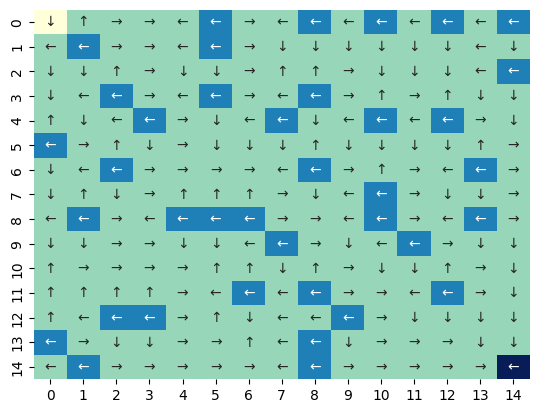

In [49]:
vi = ValueIteration(mdp_p, mdp_r, gamma=0.9, epsilon = 0.0001)
vi.run()
policy = vi.policy
policy = np.reshape(policy, (15,15)).astype(str)
lake_map = gen_map
def generate_map(policy, lake_map):
    policy[policy == '0'] = "\u2190"
    policy[policy == '1'] = "\u2193"
    policy[policy == '2'] = "\u2192"
    policy[policy == '3'] = "\u2191"
    
    dict_map = {'S':0,'F':1,'H':2,'G':3}
    
    grid_array = []
    for i in lake_map:
        gridi = [dict_map[j] for j in i]
        grid_array.append(gridi)
    grid_array = np.array(grid_array)
    sns_heatmap = sns.heatmap(grid_array, cmap="YlGnBu", annot = policy, cbar=False, fmt='')
    plt.savefig('./plots/frozen_large_vi_policy_viz.png')
    plt.show()
    
generate_map(policy, lake_map)    

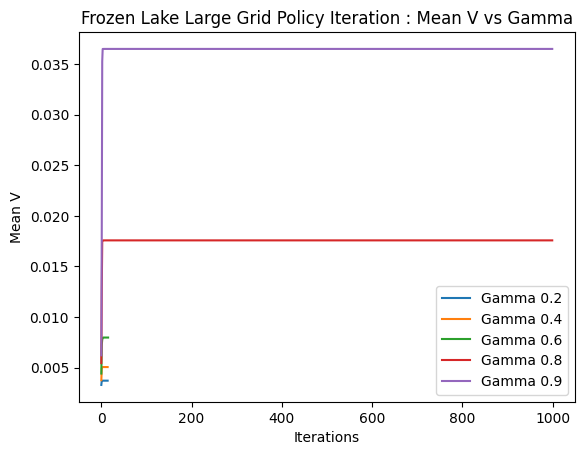

In [50]:
# Policy Iteration Gamma plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Mean V'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Mean V'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Mean V'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Mean V'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Mean V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Frozen Lake Large Grid Policy Iteration : Mean V vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_large_pi_meanv_gamma.png')
plt.show()

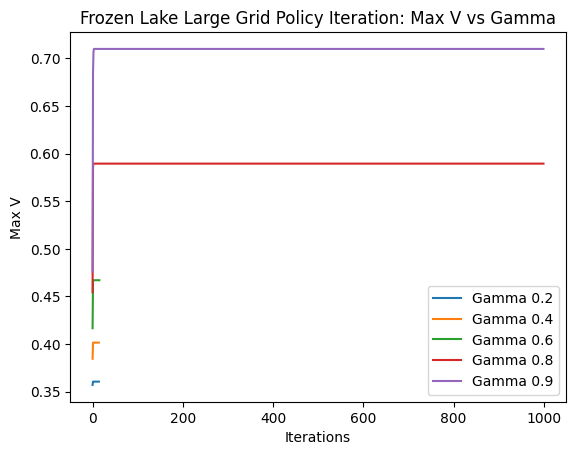

In [51]:
# Policy Iteration Gamma plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Max V'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Max V'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Max V'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Max V'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Max V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Frozen Lake Large Grid Policy Iteration: Max V vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_large_pi_maxv_gamma.png')
plt.show()

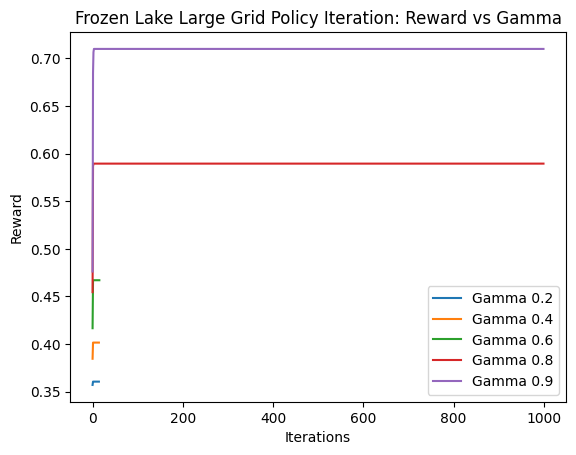

In [52]:
# Policy Iteration Reward plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Reward'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Reward'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Reward'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Reward'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Reward'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Frozen Lake Large Grid Policy Iteration: Reward vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_large_pi_reward_gamma.png')
plt.show()

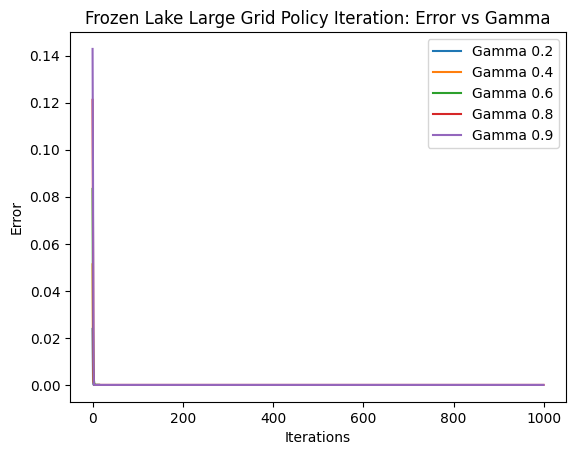

In [53]:
# Policy Iteration Error plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Error'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Error'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Error'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Error'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Error'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Frozen Lake Large Grid Policy Iteration: Error vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_large_pi_error_gamma.png')
plt.show()

           gamma      Time  Iteration     Max V
gamma                                          
0.2   14     0.2  0.117910         15  0.360601
0.4   14     0.4  0.030896         15  0.401590
0.6   15     0.6  0.046880         16  0.467060
0.8   999    0.8  2.640355       1000  0.589484
0.9   999    0.9  3.416970       1000  0.709906


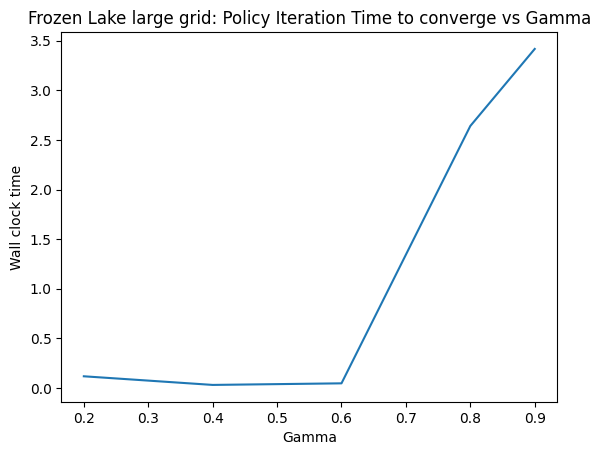

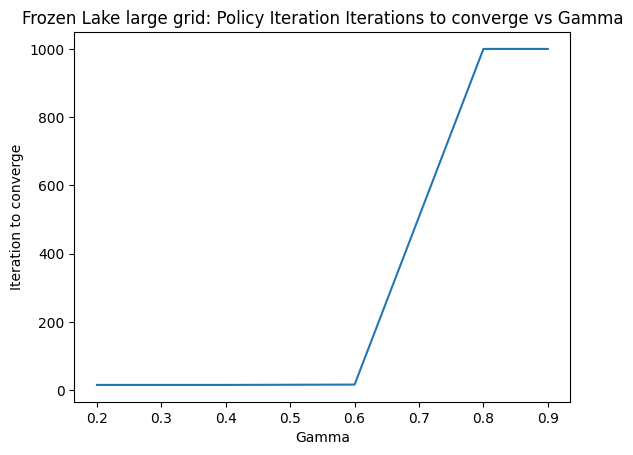

In [54]:
plg = pd.DataFrame(pol_iter_df[['gamma','Time','Iteration','Max V']].
                   groupby('gamma').apply(lambda x: x.iloc[[ -1]]))
print(plg)

plt.plot(plg['gamma'], plg['Time'])
plt.xlabel('Gamma')
plt.ylabel('Wall clock time')
plt.title('Frozen Lake large grid: Policy Iteration Time to converge vs Gamma')
plt.savefig('./plots/frozen_large_pi_time_gamma.png')
plt.show()

plt.plot(plg['gamma'], plg['Iteration'])
plt.xlabel('Gamma')
plt.ylabel('Iteration to converge')
plt.title('Frozen Lake large grid: Policy Iteration Iterations to converge vs Gamma')
plt.savefig('./plots/frozen_large_pi_iterations_gamma.png')
plt.show()

In [32]:
print(pol_iter_df)

    State Action    Reward         Error      Time     Max V    Mean V  \
0    None   None  0.357143  2.380952e-02  0.014479  0.357143  0.003304   
1    None   None  0.360601  1.717147e-03  0.016790  0.360601  0.003710   
2    None   None  0.360601  1.243587e-04  0.020351  0.360601  0.003722   
3    None   None  0.360601  9.041234e-06  0.021333  0.360601  0.003723   
4    None   None  0.360601  2.254095e-07  0.034959  0.360601  0.003723   
..    ...    ...       ...           ...       ...       ...       ...   
995  None   None  0.709906  1.110223e-16  3.406407  0.709906  0.036476   
996  None   None  0.709906  1.110223e-16  3.407231  0.709906  0.036476   
997  None   None  0.709906  1.110223e-16  3.408645  0.709906  0.036476   
998  None   None  0.709906  1.110223e-16  3.414986  0.709906  0.036476   
999  None   None  0.709906  1.110223e-16  3.416970  0.709906  0.036476   

     Iteration  gamma  
0            1    0.2  
1            2    0.2  
2            3    0.2  
3            4 

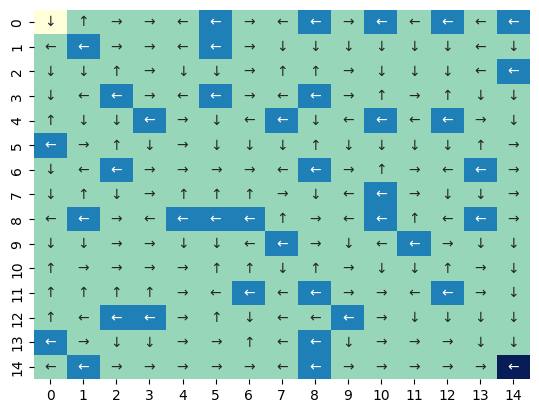

In [55]:
pi = PolicyIteration(mdp_p, mdp_r, gamma=0.9)
pi.run()
policy = pi.policy
policy = np.reshape(policy, (15,15)).astype(str)
lake_map = gen_map
def generate_map(policy, lake_map):
    policy[policy == '0'] = "\u2190"
    policy[policy == '1'] = "\u2193"
    policy[policy == '2'] = "\u2192"
    policy[policy == '3'] = "\u2191"
    
    dict_map = {'S':0,'F':1,'H':2,'G':3}
    
    grid_array = []
    for i in lake_map:
        gridi = [dict_map[j] for j in i]
        grid_array.append(gridi)
    grid_array = np.array(grid_array)
    sns_heatmap = sns.heatmap(grid_array, cmap="YlGnBu", annot = policy, cbar=False, fmt='')
    plt.savefig('./plots/frozen_large_pi_policy_viz.png')
    plt.show()
    
generate_map(policy, lake_map)    

# Q Learning

In [ ]:
# Reference: https://www.baeldung.com/cs/epsilon-greedy-q-learning


In [35]:
def run_ql(gamma_val=[0.8], alpha_val=[1], epsilon_val=[1], ad=[0.9], ed=[0.95], iteration=[1e5]):
   
    
    ind_size = len(gamma_val)*len(alpha_val)*len(epsilon_val)*len(ad)*len(ed)*len(iteration)
    ql_df = pd.DataFrame(0,index=np.arange(ind_size), 
                         columns=['gamma','alpha','epsilon','alpha_decay','epsilon_decay','time',
                                  'iterations','reward','mean_rewards','max_rewards','error','policy'])
    qlearn_df = pd.DataFrame()
    counter_val = 0
    for j in alpha_val:
        for k in epsilon_val:
            for l in ad:
                for m in ed:
                    for n in iteration:
#                         ql = QLearning(mdp_p, mdp_r, n_iter=n, gamma=0.8, alpha=j, epsilon=k,
#                                        alpha_decay=l, epsilon_decay=m, alpha_min=0.001)
                        ql = QLearning(mdp_p, mdp_r, n_iter=n, gamma=0.9, alpha=j, epsilon=k
                                       )
                        qlo = ql.run()
                        temp_df = pd.DataFrame(ql.run())
                        temp_df['gamma'] = 0.9
                        temp_df['alpha'] = j
                        temp_df['epsilon'] = k
                        temp_df['alpha_decay'] = l
                        temp_df['epsilon_decay'] = m
                        temp_df['n_iter'] = n
                        time  = qlo[-1]['Time']
                        iters = qlo[-1]['Iteration']
                        max_val  = qlo[-1]['Max V']
                        max_rewards, mean_rewards, errors = [], [], []
                        for o in qlo:
                            max_rewards.append(o['Max V'])
                            mean_rewards.append(o['Mean V'])
                            errors.append(o['Error']) 
                        policy = np.array(ql.policy)
                        policy = np.reshape(policy, (15,15))
                        
                        ql_df['gamma'][counter_val] = 0.9
                        ql_df['alpha'][counter_val] = j
                        ql_df['epsilon'][counter_val] = k
                        ql_df['alpha_decay'][counter_val] = l
                        ql_df['epsilon_decay'][counter_val] = m
                        ql_df['time'][counter_val] = time
                        ql_df['iterations'][counter_val] = iters
                        ql_df['reward'][counter_val] = max_val
                        ql_df['mean_rewards'][counter_val] = {tuple(mean_rewards)}
                        ql_df['max_rewards'][counter_val] = {tuple(max_rewards)}
                        ql_df['error'][counter_val] = {tuple(errors)}
                        ql_df['policy'][counter_val] = {ql.policy}
                        
                        counter_val += 1
                        
                        
                        qlearn_df = qlearn_df.append(temp_df)
                        
                        
    return ql_df,qlearn_df
                        
                        


In [37]:
init_time = time.time()
ql_df,qlearn_df = run_ql(gamma_val=[0.9], alpha_val=[0.8], epsilon_val=[0.6], ad=[0.9], ed=[0.95], iteration=[1e7])
print("Time taken to run:", time.time() - init_time)

Time taken to run: 1342.6915261745453


In [39]:
init_time = time.time()
ql_df,qlearn_df = run_ql(gamma_val=[0.9], alpha_val=[0.8], epsilon_val=[0.1,0.2,0.4,0.6,0.8,0.9], ad=[0.9], ed=[0.95], iteration=[1e7])
print("Time taken to run:", time.time() - init_time)

Time taken to run: 25074.4093208313


In [61]:
ql_df

,gamma,alpha,epsilon,alpha_decay,epsilon_decay,time,iterations,reward,mean_rewards,max_rewards,error,policy
0,0.9,0.8,0.1,0.9,0.95,669.091337,10000000,0.413336,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(2, 3, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,..."
1,0.9,0.8,0.2,0.9,0.95,670.260109,10000000,0.439859,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0, 2, 1, 2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0,..."
2,0.9,0.8,0.4,0.9,0.95,671.761943,10000000,0.474246,"{(5.754131571030867e-05, 5.754131571030867e-05...","{(0.012946796034819451, 0.012946796034819451, ...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(1, 1, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 1, 0,..."
3,0.9,0.8,0.6,0.9,0.95,670.587671,10000000,0.606835,"{(0.0004367356895278247, 0.0004367356895278247...","{(0.09784434904852166, 0.09784434904852166, 0....","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(2, 1, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0,..."
4,0.9,0.8,0.8,0.9,0.95,667.256486,10000000,0.481111,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.48...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(1, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
5,0.9,0.8,0.9,0.9,0.95,673.197921,10000000,0.454201,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(2, 3, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0,..."


In [189]:
qlearn_df

,State,Action,Reward,Error,Time,Alpha,Epsilon,Gamma,Max V,Mean V,Iteration,gamma,alpha,epsilon,alpha_decay,epsilon_decay,n_iter
0,2,0,0.0,0.0,0.000242,0.001,0.1,0.8,0.011471,0.000248,10,0.8,0.8,0.1,0.9,0.95,100000.0
1,16,0,0.0,0.0,0.000525,0.001,0.1,0.8,0.011471,0.000248,20,0.8,0.8,0.1,0.9,0.95,100000.0
2,16,0,0.0,0.0,0.000787,0.001,0.1,0.8,0.011471,0.000248,30,0.8,0.8,0.1,0.9,0.95,100000.0
3,16,0,0.0,0.0,0.001052,0.001,0.1,0.8,0.011471,0.000248,40,0.8,0.8,0.1,0.9,0.95,100000.0
4,49,0,0.0,0.0,0.001410,0.001,0.1,0.8,0.011471,0.000248,50,0.8,0.8,0.1,0.9,0.95,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,0,0.0,0.0,3.379601,0.001,0.1,0.8,0.040859,0.001015,99960,0.8,0.8,0.9,0.9,0.95,100000.0
9996,35,0,0.0,0.0,3.379936,0.001,0.1,0.8,0.040859,0.001015,99970,0.8,0.8,0.9,0.9,0.95,100000.0
9997,35,0,0.0,0.0,3.380279,0.001,0.1,0.8,0.040859,0.001015,99980,0.8,0.8,0.9,0.9,0.95,100000.0
9998,35,0,0.0,0.0,3.380621,0.001,0.1,0.8,0.040859,0.001015,99990,0.8,0.8,0.9,0.9,0.95,100000.0


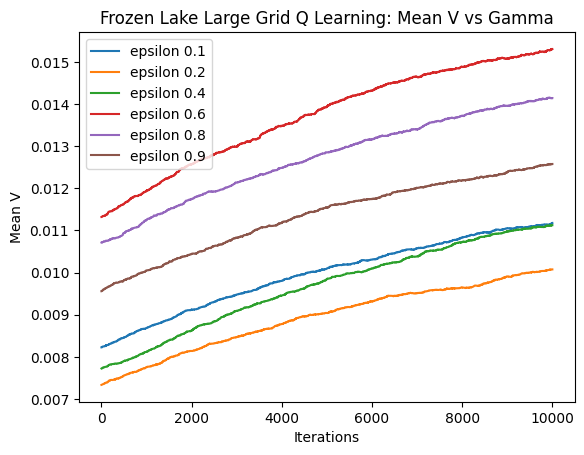

In [56]:
plt.figure()
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.1]['Mean V'], label = "epsilon 0.1")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.2]['Mean V'], label = "epsilon 0.2")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.4]['Mean V'], label = "epsilon 0.4")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.6]['Mean V'], label = "epsilon 0.6")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.8]['Mean V'], label = "epsilon 0.8")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.9]['Mean V'], label = "epsilon 0.9")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Frozen Lake Large Grid Q Learning: Mean V vs Gamma')
plt.legend()
#plt.savefig('./plots/frozen_large_QL_meanv_gamma.png')
plt.show()

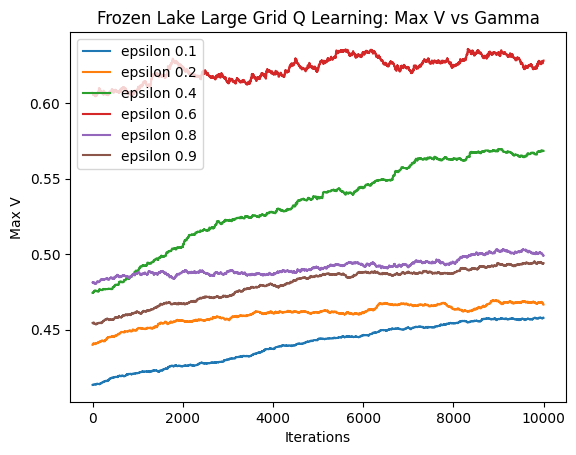

In [62]:
plt.figure()
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.1]['Max V'], label = "epsilon 0.1")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.2]['Max V'], label = "epsilon 0.2")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.4]['Max V'], label = "epsilon 0.4")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.6]['Max V'], label = "epsilon 0.6")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.8]['Max V'], label = "epsilon 0.8")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.9]['Max V'], label = "epsilon 0.9")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Frozen Lake Large Grid Q Learning: Max V vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_large_QL_maxv_gamma.png')
plt.show()

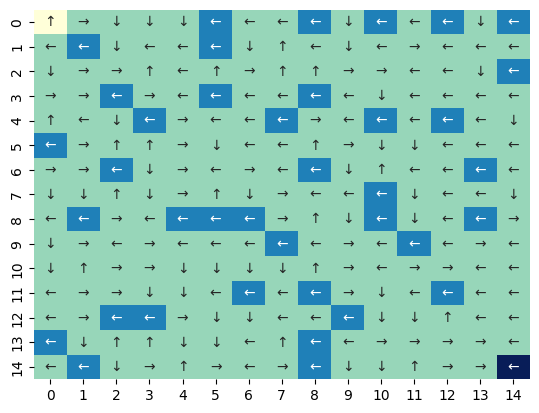

In [58]:
ql = QLearning(mdp_p, mdp_r, n_iter=1e7, gamma=0.9, alpha=0.8, epsilon=0.6)
ql.run()
policy = ql.policy
policy = np.reshape(policy, (15,15)).astype(str)
lake_map = gen_map
def generate_map(policy, lake_map):
    policy[policy == '0'] = "\u2190"
    policy[policy == '1'] = "\u2193"
    policy[policy == '2'] = "\u2192"
    policy[policy == '3'] = "\u2191"
    
    dict_map = {'S':0,'F':1,'H':2,'G':3}
    
    grid_array = []
    for i in lake_map:
        gridi = [dict_map[j] for j in i]
        grid_array.append(gridi)
    grid_array = np.array(grid_array)
    sns_heatmap = sns.heatmap(grid_array, cmap="YlGnBu", annot = policy, cbar=False, fmt='')
    plt.savefig('./plots/frozen_large_QL_policy_viz.png')
    plt.show()
    
generate_map(policy, lake_map)    

              epsilon          Time  Iteration     Max V
epsilon                                                 
0.1     9999      0.1    671.165974   10000000  0.457763
0.2     9999      0.2    671.839933   10000000  0.466543
0.4     9999      0.4    675.010939   10000000  0.568237
0.6     9999      0.6    670.967239   10000000  0.628095
0.8     9999      0.8    665.258348   10000000  0.499018
0.9     9999      0.9  17697.555890   10000000  0.493858


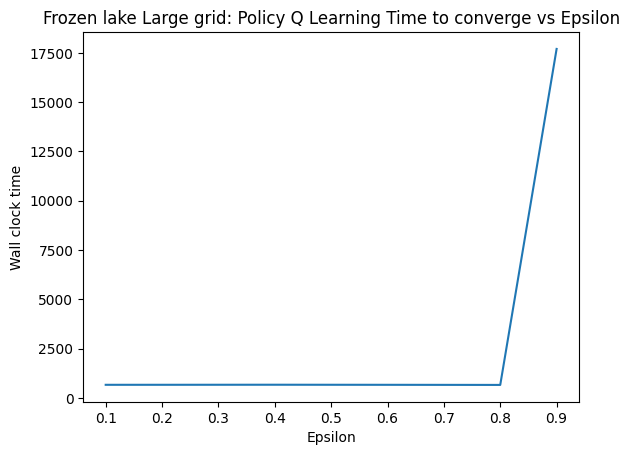

In [60]:
qlg = pd.DataFrame(qlearn_df[['epsilon','Time','Iteration','Max V']].
                   groupby('epsilon').apply(lambda x: x.iloc[[ -1]]))
print(qlg)

plt.plot(qlg['epsilon'], qlg['Time'])
plt.xlabel('Epsilon')
plt.ylabel('Wall clock time')
plt.title('Frozen lake Large grid: Policy Q Learning Time to converge vs Epsilon')
plt.savefig('./plots/frozen_large_ql_time_eps.png')
plt.show()